https://colab.research.google.com/drive/1zqSgHRY4v4i1uBxKOB44CaZrIUXwjRRt

In [0]:
import os
from google.colab import drive

ROOT = "/content/drive"
PROJ = "My Drive/DriveUploader/big_data"

drive.mount(ROOT)

Mounted at /content/drive


In [0]:
!unzip -oq "/content/drive/My Drive/DriveUploader/big_data.zip"
PROJECT_PATH_TRAIN_LOCAL ="./big_data/train/"  # if command executed earlier !unzip -oq "/content/drive/My Drive/DriveUploader/small_data.zip"

In [0]:
!unzip -oq "/content/drive/My Drive/DriveUploader/small_data.zip"
PROJECT_PATH_TRAIN_LOCAL ="./small_data/train/"  # if command executed earlier !unzip -oq "/content/drive/My Drive/DriveUploader/small_data.zip"

In [0]:


"""
inspired by Jason M. Manley, 2018
jmanley@rockefeller.edu
https://github.com/jmmanley/conv-autoencoder/
"""

PROJECT_PATH = os.path.join(ROOT, PROJ)
PROJECT_PATH_VALIDATION = os.path.join(PROJECT_PATH, "validation")
PROJECT_PATH_TEST = os.path.join(PROJECT_PATH, 'test/image')
PROJECT_PATH_DEBUG = os.path.join(PROJECT_PATH, 'debug')

INPUT_SIZE = (160,480)
INPUT_SIZE3 = INPUT_SIZE + (1,)  #(160,480,1)
TRAIN_SIZE= len(os.listdir(os.path.join(PROJECT_PATH_TRAIN_LOCAL, "image"))) #280 #11935
TEST_SIZE = len(os.listdir(os.path.join(PROJECT_PATH, "test/image"))) 
BATCH_SIZE = 2
STEPS_PEPOCH=TRAIN_SIZE//BATCH_SIZE
NUM_CLASSES=5

%tensorflow_version 1.x



from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import cv2

#this map is how keras image generator converts colored images into grayscale pixels
background = 0      #corresponds to color 0,0,0        black
class1 = 105 #77     #corresponds to color 0,102,153
class2 = 176  #129    #corresponds to color 0,170,255
class3 = 222 #177      #corresponds to color 0,255,244
class4 = 255           #corresponds to color 255,255,255  white

# sometimes ImageGeneratro converts colored mask into grayscale pixels differently - for example 105 or 106, or 222/223
class1ext = 106
class3ext = 223

# Grayscale dictionary to convert mask image into one-hot encoded 5-class label (and back if required).
# Colored mask becomes graysclale when opened in respective mode
GRAY_DICT = np.array([background, class1, class2, class3, class4, class1ext, class3ext])


def img_resize(img, target_size):
  #print(f"img_resize img.shape {img.shape}")
  new_img = np.zeros(img.shape)
  img = np.reshape(img, (img.shape[0], img.shape[1], img.shape[2])) ## casting to simpler dimensions like (160, 480) not  (160, 480, 1)
  #print(f"img_resize reshaped img.shape {img.shape}")
  for i, single_img in enumerate(img):
      single_img = cv2.resize(single_img, (target_size[1], target_size[0]), interpolation = cv2.INTER_NEAREST) # cv image size format (width, heigth) so I need to swap
      single_img = np.reshape(single_img,single_img.shape+(1,))  # casting back to tensor format  (160, 480, 1)
      new_img[i] = single_img
  return new_img


def adjustData5cl(img,mask,num_class, target_size, batch_size, resize=False):    

    if(resize):
        #print(f" before resize  np.unique(mask) {np.unique(mask)}")
        mask = img_resize(mask, target_size)
        img = img_resize(img, target_size) 
        #print(f" after resize  np.unique(mask) {np.unique(mask)}")   
    
    img = img / 255

    #mask = np.where(mask==GRAY_DICT[4], 4, mask)   # backround pixels with value 0 are already treated as class0
    mask = np.where(mask==GRAY_DICT[1], 1, mask) 
    mask = np.where(mask==class1ext, 1, mask)
    mask = np.where(mask==GRAY_DICT[2], 2, mask)
    mask = np.where(mask==GRAY_DICT[3], 3, mask)
    mask = np.where(mask==class3ext, 3, mask)
    mask = np.where(mask==GRAY_DICT[4], 4, mask)

    #print(f"call categorical adjustData5cl, mask.shape={mask.shape}") 
    #print(f"np.unique(mask) {np.unique(mask)}")     
    mask = to_categorical(mask, NUM_CLASSES)    # using Keras lib funcion to one-hot encode
    return (img,mask)   


def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 5,save_to_dir = None,target_size = (160,480), rescale = False, seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:        
        img,mask = adjustData5cl(img,mask,num_class, target_size, batch_size, resize = rescale)
        yield (img,mask)



def testGenerator(test_path,num_image = TEST_SIZE, resize = False, target_size = INPUT_SIZE):
    files = os.listdir(test_path)
    files.sort()
    for i,  filename in enumerate (files):
        img = cv2.imread(os.path.join(test_path, filename), 0)    
        if(resize):
            img = cv2.resize(img, (target_size[1], target_size[0]), interpolation = cv2.INTER_NEAREST)  # cv image size format (width, heigth) so I need to swap  
        img = img / 255
        img = np.reshape(img,img.shape+(1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img


def saveResult(save_dir,results, num_class = 5):
    rshape = results.shape
    batch = np.reshape(results, (rshape[0] * rshape[1] * rshape[2], num_class))
    new_batch = np.zeros(batch.shape[0])
    
    for i in range (batch.shape[0]):
        new_batch[i] = GRAY_DICT[np.argmax(batch[i, :])]   #convering one-hot encoded output to flat grayscale image
    
    new_batch = np.reshape(new_batch, (rshape[0], rshape[1], rshape[2]), 'C');	
    
    for i in range(new_batch.shape[0]):
      img = new_batch[i]
      fl = os.path.join(save_dir, str(i)+".bmp")      
      cv2.imwrite(fl, img)
    print(f"Results saved to folder {save_dir}")

def saveAutoResult(save_dir,rtensor):
    #rshape = results.shape
    batch = np.squeeze(rtensor*255)    
    
    for i, img in enumerate (batch):
        fl = os.path.join(save_dir, str(i).zfill(5) +".bmp")      
        cv2.imwrite(fl, img)

    print(f"Results saved to folder {save_dir}")    

def saveResultColored(save_dir,results, num_class = 5):
    background = np.array([0,0,0])
    class1 = np.array([0,102,153])
    class2 = np.array([0,170,255])
    class3 = np.array([0,255,244])
    class4 = np.array([255,255,255])
    COLOR_DICT = np.array([background, class1, class2, class3, class4])

    rshape = results.shape

    batch = np.reshape(results, (rshape[0] * rshape[1] * rshape[2], num_class))
    new_batch = np.zeros((batch.shape[0], 3))
    
    for i in range (batch.shape[0]):
        new_batch[i] = COLOR_DICT[np.argmax(batch[i, :])]

    new_batch = np.reshape(new_batch, (rshape[0], rshape[1], rshape[2], 3), 'C');	    

    for i in range(new_batch.shape[0]):
      img = new_batch[i]
      fl = os.path.join(save_dir, str(i).zfill(5) +".bmp")      
      cv2.imwrite(fl, img)
    print(f"Results saved to folder {save_dir}") 



def debugSave(ts_img, path=PROJECT_PATH_DEBUG, pref='train'):      
    for i in range(ts_img.shape[0]):
        img = ts_img[i]
        img = np.reshape(img, (160, 480))
        #img = img * 255
        fl = os.path.join(path, pref+str(i)+".bmp")      
        cv2.imwrite(fl, img)

def trainAutoGenerator(batch_size,train_path,image_folder,aug_dict,image_color_mode = "grayscale",
                    image_save_prefix  = "image",mask_save_prefix  = "image", save_to_dir = None,
                    target_size = INPUT_SIZE,rescale = False, seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)    
    for img in image_generator:
        if(rescale):            
            img = img_resize(img, target_size) 
        img = img/255        
        yield (img,img)

      

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import os


class UnetEncoderSmall:
    #constructing encoder part (uncompiled)
    def __init__(self, input_size = INPUT_SIZE3):
      
        self.i = 0
        self.inputs = Input(input_size)
        self.conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(self.inputs)
        #self.conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(self.conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(self.conv1)
        self.conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        #self.conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(self.conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(self.conv2)
        self.conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        #self.conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(self.conv3)

        pool3 = MaxPooling2D(pool_size=(2, 2))(self.conv3)
        self.conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        #self.conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(self.conv4)
        #self.drop4 = Dropout(0.5)(self.conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(self.conv4)
        
        self.conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        #self.conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(self.conv5)
        
        self.drop5 = Dropout(0.5)(self.conv5)
        self.encoder = Model(input = self.inputs, output = self.conv5)
    
 
        
    def save_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.save_weights(os.path.join(path, prefix + "autoencoder_weights.h5"))        
        
    def load_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.load_weights(os.path.join(path, prefix + "autoencoder_weights.h5"))

    def get_concat_layers(self):
        return(self.conv1, self.conv2, self.conv3, self.conv4)
    
    def get_input_layer(self):
        return(self.inputs)

    def get_last_layer(self):
        return(self.drop5)
		
    def set_test_var(self, i):
        self.i=i

    def get_test_var(self):
        return self.i		


class UnetFullSmall:    # don't use it   
     #constucting full Unet for training with labels
     def __init__(self, encoder):
         drop5 = encoder.get_last_layer()
         encoder_layers = encoder.get_concat_layers()
         encoder.set_test_var(10)
         self.enc = encoder
		              
         pre_conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop5)        
         up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pre_conv6))
         conv4 = encoder_layers[3]
         merge6 = concatenate([conv4,up6], axis = 3)
         conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
         #conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
         
         up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
         conv3 = encoder_layers[2]
         merge7 = concatenate([conv3,up7], axis = 3)
         conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
         #conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
        
         
         up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
         conv2 = encoder_layers[1]
         merge8 = concatenate([conv2,up8], axis = 3)
         conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
         #conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
         
         up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
         conv1 = encoder_layers[0]
         merge9 = concatenate([conv1,up9], axis = 3)
         conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
         #conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
         #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
         conv10 = Conv2D(5, 1, activation = 'softmax')(conv9)
         
         self.model = Model(input = encoder.get_input_layer(), output = conv10)         
         self.model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
            
     def get_model(self):         
            return self.model
		
     def get_encoder(self):
            return self.enc	

class UnetAutoSmall:       
     #constucting autoencoder Unet
     def __init__(self, encoder):
         self.enc = encoder
         
         drop5 = encoder.get_last_layer()         
         pre_conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop5)  
         conv6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pre_conv6))         
         conv7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6)) 
         conv8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))         
         conv9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
         conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
         
         self.model = Model(input = encoder.get_input_layer(), output = conv10)         
         self.model.compile(optimizer = RMSprop(), loss = 'mean_squared_error', metrics = ['accuracy'])
         
     def get_model(self):         
            return self.model

     def get_encoder(self):
            return self.enc	       

class UnetExtra:       
     #constucting autoencoder Unet
     def __init__(self, encoder):
         drop5 = encoder.get_last_layer()
         pre_conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop5)  
         conv6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pre_conv6))         
         conv7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6)) 
         conv8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))         
         conv9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))         
         conv10 = Conv2D(5, 1, activation = 'softmax')(conv9)
         
         self.model = Model(input = encoder.get_input_layer(), output = conv10)         
         self.model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
         
     def get_model(self):         
            return self.model

In [0]:
#validation data


import cv2

def prepare_validation(val_folder = PROJECT_PATH_VALIDATION ):
  
    background = 0
    class1 = 77
    class2 = 129
    class3 = 177
    class4 = 255
    
    # Grayscale dictionary to convert mask image into one-hot encoded 5-class label (and back if required).
    # Colored mask becomes graysclale when opened in respective mode
    # cv library converts differently from image generatory so I need to use different dictionary
    GRAY_DICT_CV = np.array([background, class1, class2, class3, class4])
    
    #validation auto
    PROJECT_PATH_VALIDATION_IM = os.path.join(PROJECT_PATH_VALIDATION, 'image')
    val_num = len(os.listdir(PROJECT_PATH_VALIDATION_IM))
    print(f"Validation batch size: {val_num}")
    
    
    
    val_auto=np.zeros((val_num, INPUT_SIZE[0], INPUT_SIZE[1], 1))
    for i,  filename in enumerate (os.listdir(PROJECT_PATH_VALIDATION_IM)):
        img = cv2.imread(os.path.join(PROJECT_PATH_VALIDATION_IM, filename), 0)
        if(img.shape != INPUT_SIZE):
            print("resizing val images")
            img = cv2.resize(img, (INPUT_SIZE[1], INPUT_SIZE[0]), interpolation = cv2.INTER_NEAREST)  # cv image size format (width, heigth) so I need to swap
        img = img.astype('float32') / 255
        img = np.reshape(img,img.shape+(1,))
        val_auto[i] = img
    
    
    
    PROJECT_PATH_VALIDATION_MASK = os.path.join(PROJECT_PATH_VALIDATION, 'label')
    
    #validation label
    val_hot_encoded=np.zeros((val_num, INPUT_SIZE[0], INPUT_SIZE[1], len(GRAY_DICT_CV)))
    for i,  filename in enumerate (os.listdir(PROJECT_PATH_VALIDATION_MASK)):
        mask = cv2.imread(os.path.join(PROJECT_PATH_VALIDATION_MASK, filename), 0)
        if(mask.shape != INPUT_SIZE):
          #print("resizing validation masks")
          mask = cv2.resize(mask, (INPUT_SIZE[1], INPUT_SIZE[0]), interpolation = cv2.INTER_NEAREST)  # cv image size format (width, heigth) so I need to swap
        #mask = np.where(mask==GRAY_DICT_CV[4], 4, mask)   # backround pixels with value 0 are already treated as class0
        mask = np.where(mask==GRAY_DICT_CV[1], 1, mask) 
        mask = np.where(mask==GRAY_DICT_CV[2], 2, mask)
        mask = np.where(mask==GRAY_DICT_CV[3], 3, mask)
        mask = np.where(mask==GRAY_DICT_CV[4], 4, mask)
        
        #print(f"to_categorical, validation, np.unique(mask) = {np.unique(mask)}" )
        mask = to_categorical(mask, len(GRAY_DICT_CV))    # using Keras lib funcion to one-hot encode
        val_hot_encoded[i] = mask  
    return val_auto,  val_hot_encoded   

val_auto, val_hot_encoded = prepare_validation()

# simplified plotting function as alternative to tensorboard
import matplotlib.pyplot as plt

def plot_curves(history):
 plt.figure(figsize=(16, 6))
 plt.subplot(1, 2, 1)
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.xlabel('Epoch')
 plt.ylabel('Loss')
 plt.legend(['Training', 'Validation'])
 plt.title('Loss')
 plt.subplot(1, 2, 2)
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy')
 plt.legend(['Training', 'Validation'])
 plt.title('Accuracy')


from keras.callbacks import TensorBoard
import keras.backend as K
K.clear_session()

LOG_DIR = 'tb_logs'

tbCallBack = TensorBoard(log_dir=LOG_DIR, 
                         histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=BATCH_SIZE,
                         write_images=True)


Validation batch size: 5
resizing val images
resizing val images
resizing val images
resizing val images
resizing val images


In [0]:
import keras.backend as K
K.clear_session()

encoder = UnetEncoderSmall()
#encoder.load_weights()
unet = UnetAutoSmall(encoder)
unet_auto = unet.get_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
unet_auto.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 480, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 480, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 480, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 240, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 240, 64)       18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 240, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 120, 64)       0   

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard
import tensorflow as tf
import datetime

'''
"/content/drive/My Drive/DriveUploader/big_data/debug/tensorlogs_junk2"  - use this sring when reading logs (and folder must be created beforehand)
%tensorboard --logdir  "/content/drive/My Drive/DriveUploader/big_data/debug/tensorlogs_auto"
It's better to launch tensorboard in separate notebook to avoid any javaScript failures in current Colab notebook
'''
PROJECT_PATH_TENSORLOGS = os.path.join(PROJECT_PATH_DEBUG, 'tensorlogs_auto')
logdir = os.path.join(PROJECT_PATH_TENSORLOGS, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [0]:
 #%reload_ext tensorboard

In [0]:
PROJECT_PATH_DEBUG = os.path.join(PROJECT_PATH, 'debug')
encoder.save_weights(PROJECT_PATH_DEBUG)

In [0]:
PROJECT_PATH_TRAIN = os.path.join(PROJECT_PATH, 'train')
PROJECT_PATH_DEBUG = os.path.join(PROJECT_PATH, 'debug')
PROJECT_PATH_DEBUG_AUTO = os.path.join(PROJECT_PATH_DEBUG, 'unet_auto_membrane.hdf5')

INPUT_SIZE = (160,480)
INPUT_SIZE3 = INPUT_SIZE + (1,)  #(160,480,1)
TRAIN_SIZE= len(os.listdir(os.path.join(PROJECT_PATH_TRAIN_LOCAL, "image"))) #280 #11935
TEST_SIZE = len(os.listdir(os.path.join(PROJECT_PATH, "test/image"))) 
BATCH_SIZE = 2
STEPS_PEPOCH=TRAIN_SIZE//BATCH_SIZE

data_gen_args = dict()

'''
#use when training session interrupted
encoder = UnetEncoderSmall()
unet = UnetAutoSmall(encoder)
unet_auto = unet.get_model()
unet_auto.loadWeights(PROJECT_PATH_DEBUG_AUTO)
'''
autoGen = trainAutoGenerator(BATCH_SIZE, PROJECT_PATH_TRAIN_LOCAL,'image', image_color_mode = "grayscale", aug_dict=data_gen_args, target_size = INPUT_SIZE)
model_checkpoint = ModelCheckpoint(PROJECT_PATH_DEBUG_AUTO, monitor='loss',verbose=1, save_best_only=True)
history = unet_auto.fit_generator(autoGen,steps_per_epoch=STEPS_PEPOCH,epochs=20, callbacks=[], validation_data = (val_auto, val_auto))

Found 756 images belonging to 1 classes.
Epoch 1/20
378/378 [==============================] - 15s 40ms/step - loss: 0.0119 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0143
Epoch 2/20
378/378 [==============================] - 15s 39ms/step - loss: 0.0114 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0143
Epoch 3/20
378/378 [==============================] - 15s 38ms/step - loss: 0.0114 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0143
Epoch 4/20
378/378 [==============================] - 15s 38ms/step - loss: 0.0114 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0143
Epoch 5/20
378/378 [==============================] - 15s 38ms/step - loss: 0.0114 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0143
Epoch 6/20
378/378 [==============================] - 15s 38ms/step - loss: 0.0114 - accuracy: 0.0066 - val_loss: 0.0144 - val_accuracy: 0.0143
Epoch 7/20
378/378 [==============================] - 14s 38ms/step - loss: 0.0114 - accuracy: 

KeyboardInterrupt: ignored

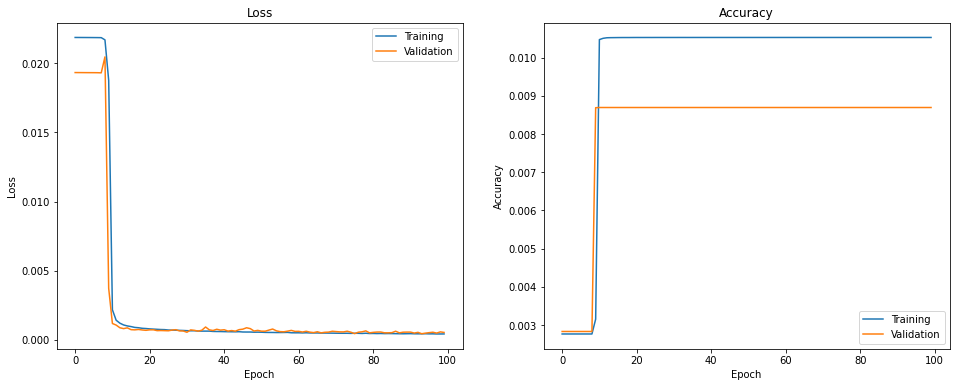

In [0]:
plot_curves(history)

In [0]:
encoder.save_weights(PROJECT_PATH_DEBUG)

In [0]:
PROJECT_PATH_TEST = os.path.join(PROJECT_PATH, 'test')
PROJECT_PATH_TEST_RESULT = os.path.join(PROJECT_PATH, 'test_results')
testGene = testGenerator(PROJECT_PATH_TEST)
#model = unet(pretrained_weights = None,input_size = (160,480,1))
#model.load_weights("unet_membrane.hdf5")
results = unet_auto.predict_generator(testGene,30,verbose=1)
#saveResult(PROJECT_PATH_TEST_RESULT, results)



30/30 [==============================] - 8s 275ms/step


In [0]:
saveResutsAutoencoded(PROJECT_PATH_TEST_RESULT, results)

Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n0.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n1.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n2.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n3.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n4.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n5.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n6.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n7.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n8.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n9.bmp
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results/n10.bmp
Results saved to folder /content/drive/My 

In [0]:
encoder = UnetEncoderSmall()
encoder.load_weights(PROJECT_PATH_DEBUG)
unet = UnetFullSmall(encoder)
unet_full = unet.get_model()





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("dr...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
PROJECT_PATH_TRAIN = os.path.join(PROJECT_PATH, 'train')
PROJECT_PATH_DEBUG = os.path.join(PROJECT_PATH, 'debug')
PROJECT_PATH_DEBUG_AUTO = os.path.join(PROJECT_PATH_DEBUG, 'unet_full_small_membrane.hdf5')

INPUT_SIZE = (160,480)
INPUT_SIZE3 = (160,480,1)
TRAIN_SIZE=280
BATCH_SIZE = 2
STEPS_PEPOCH=TRAIN_SIZE//BATCH_SIZE

data_gen_args = dict()

'''
#use when training session interrupted
encoder = UnetEncoderSmall()
unet = UnetFullSmall(encoder)
unet_full = unet.get_model()
unet_full.loadWeights(PROJECT_PATH_DEBUG_AUTO)
'''
autoGen = trainGeneratorClasses(BATCH_SIZE, PROJECT_PATH_TRAIN,'image', 'label', image_color_mode = "grayscale", aug_dict=data_gen_args, target_size = INPUT_SIZE)
model_checkpoint = ModelCheckpoint(PROJECT_PATH_DEBUG_AUTO, monitor='loss',verbose=1, save_best_only=True)
history = unet_full.fit_generator(autoGen,steps_per_epoch=STEPS_PEPOCH,epochs=100, callbacks=[model_checkpoint], validation_data = (val_auto, val_hot_encoded))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 280 images belonging to 1 classes.
Epoch 1/100
Found 280 images belonging to 1 classes.
140/140 [==============================] - 108s 775ms/step - loss: 0.7899 - accuracy: 0.6903 - val_loss: 0.6995 - val_accuracy: 0.6967

Epoch 00001: loss improved from inf to 0.78987, saving model to /content/drive/My Drive/DriveUploader/data/debug/unet_full_small_membrane.hdf5
Epoch 2/100
140/140 [==============================] - 16s 112ms/step - loss: 0.5927 - accuracy: 0.7601 - val_loss: 0.5915 - val_accuracy: 0.7610

Epoch 00002: loss improved from 0.78987 to 0.59267, saving model to /content/drive/My Drive/DriveUploader/data/debug/unet_full_small_membrane.hdf5
Epoch 3/100
140/140 [==============================] - 16s 112ms/step - loss: 0.5132 - accuracy: 0.7975 - val_loss: 0.5802 - val_accuracy: 0.7564

Epoch 00003: loss improved from 0.59267 to 0.51317, saving model to /content/drive/My Drive/

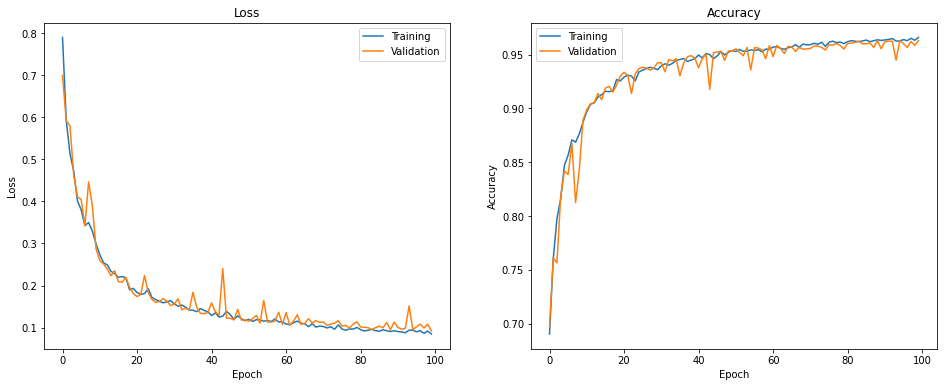

In [0]:
plot_curves(history)

In [0]:
PROJECT_PATH_TEST = os.path.join(PROJECT_PATH, 'test')
PROJECT_PATH_TEST_RESULT = os.path.join(PROJECT_PATH, 'test_results')
testGene = testGenerator(PROJECT_PATH_TEST)
#model = unet(pretrained_weights = None,input_size = (160,480,1))
#model.load_weights("unet_membrane.hdf5")
results = unet_full.predict_generator(testGene,30,verbose=1)
#saveResult(PROJECT_PATH_TEST_RESULT, results)

30/30 [==============================] - 1s 30ms/step


In [0]:
saveResultColored(PROJECT_PATH_TEST_RESULT, results)

Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results


In [0]:
encoder_new = UnetEncoderSmall()
unet = UnetFullSmall(encoder_new)
unet_full_new = unet.get_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("dr...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
PROJECT_PATH_TRAIN = os.path.join(PROJECT_PATH, 'train')
PROJECT_PATH_DEBUG = os.path.join(PROJECT_PATH, 'debug')
PROJECT_PATH_DEBUG_AUTO = os.path.join(PROJECT_PATH_DEBUG, 'unet_full_small_membrane.hdf5')

INPUT_SIZE = (160,480)
INPUT_SIZE3 = (160,480,1)
TRAIN_SIZE=280
BATCH_SIZE = 2
STEPS_PEPOCH=TRAIN_SIZE//BATCH_SIZE

data_gen_args = dict()

'''
#use when training session interrupted
encoder = UnetEncoderSmall()
unet = UnetFullSmall(encoder)
unet_full = unet.get_model()
unet_full.loadWeights(PROJECT_PATH_DEBUG_AUTO)
'''
autoGen = trainGeneratorClasses(BATCH_SIZE, PROJECT_PATH_TRAIN,'image', 'label', image_color_mode = "grayscale", aug_dict=data_gen_args, target_size = INPUT_SIZE)
model_checkpoint = ModelCheckpoint(PROJECT_PATH_DEBUG_AUTO, monitor='loss',verbose=1, save_best_only=True)
history = unet_full_new.fit_generator(autoGen,steps_per_epoch=STEPS_PEPOCH,epochs=100, callbacks=[model_checkpoint], validation_data = (val_auto, val_hot_encoded))

Found 280 images belonging to 1 classes.
Found 280 images belonging to 1 classes.
Epoch 1/100
140/140 [==============================] - 17s 119ms/step - loss: 0.8663 - accuracy: 0.6786 - val_loss: 0.6869 - val_accuracy: 0.7172

Epoch 00001: loss improved from inf to 0.86634, saving model to /content/drive/My Drive/DriveUploader/data/debug/unet_full_small_membrane.hdf5
Epoch 2/100
140/140 [==============================] - 16s 112ms/step - loss: 0.5986 - accuracy: 0.7585 - val_loss: 0.5664 - val_accuracy: 0.7695

Epoch 00002: loss improved from 0.86634 to 0.59856, saving model to /content/drive/My Drive/DriveUploader/data/debug/unet_full_small_membrane.hdf5
Epoch 3/100
140/140 [==============================] - 16s 113ms/step - loss: 0.5293 - accuracy: 0.7845 - val_loss: 0.5623 - val_accuracy: 0.7681

Epoch 00003: loss improved from 0.59856 to 0.52925, saving model to /content/drive/My Drive/DriveUploader/data/debug/unet_full_small_membrane.hdf5
Epoch 4/100
140/140 [===================

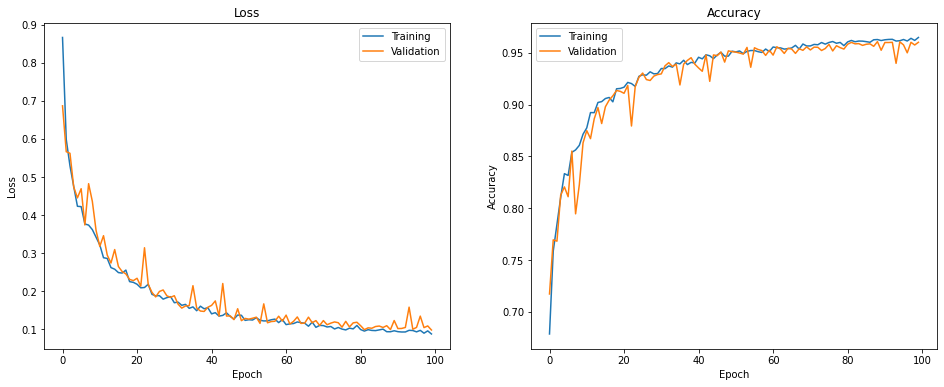

In [0]:
plot_curves(history)

In [0]:
PROJECT_PATH_TEST = os.path.join(PROJECT_PATH, 'test')
PROJECT_PATH_TEST_RESULT = os.path.join(PROJECT_PATH, 'test_results')
testGene = testGenerator(PROJECT_PATH_TEST)
#model = unet(pretrained_weights = None,input_size = (160,480,1))
#model.load_weights("unet_membrane.hdf5")
results = unet_full.predict_generator(testGene,30,verbose=1)
saveResultColored(PROJECT_PATH_TEST_RESULT, results)

30/30 [==============================] - 1s 23ms/step
Results saved to folder /content/drive/My Drive/DriveUploader/data/test_results


In [0]:
import keras.backend as K
K.clear_session()
encoder = UnetEncoderSmall()
#encoder.load_weights()
unet = UnetExtra(encoder)
unet_extra = unet.get_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
PROJECT_PATH_DEBUG = os.path.join(PROJECT_PATH, 'debug')
PROJECT_PATH_SAVED_MODEL = os.path.join(PROJECT_PATH_DEBUG, 'unet_smaller_full_training_membrane.hdf5')

unet_extra.load_weights(PROJECT_PATH_SAVED_MODEL)

In [0]:
PROJECT_PATH_TEST = os.path.join(PROJECT_PATH, 'test_ws06')
PROJECT_PATH_TEST_RESULT = os.path.join(PROJECT_PATH, 'test_results')
TEST_SIZE = len(os.listdir(PROJECT_PATH_TEST))
testGene = testGenerator(PROJECT_PATH_TEST, resize=True)
#model = unet(pretrained_weights = None,input_size = (160,480,1))
#model.load_weights("unet_membrane.hdf5")
results = unet_extra.predict_generator(testGene,TEST_SIZE,verbose=1)
#saveResult(PROJECT_PATH_TEST_RESULT, results)


88/88 [==============================] - 87s 993ms/step


In [0]:
saveResultColored(PROJECT_PATH_TEST_RESULT,results)
  

Results saved to folder /content/drive/My Drive/DriveUploader/big_data/test_results


-------------------------------------------------------------------------------------